In [12]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form> ''')

# Early Signs of A Future Housing Market Crash

This project aims to identify cities that can serve as early signs of the future housing market crash. We identified the ~250 cities that responded earliest during the housing market crash in 2007 by computing the time points when the median house prices are at the maximum (we call here, tipping points). We show the cities' common characteristics are small in their city populations and low in their growth rates based on Gaussian Mixture Model clustering. 34% of the cities were found to already reach their tipping point (max median house prices) as of now (October 2016) and start to decrease in their median house prices. In other words, the risk level of the next housing market crash is 34%. In addition, we identified most investable cities in the US, which are Bellevue and Redmond in Washington and Palo Alto, Cupertino, Sunnyvale, San Francisco, San Mateo, Redwood City, Mountain View, South San Francisco, Daly City, and Montebello in California. 

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter

output_notebook(hide_banner = True)

### Data used in this project
1. The historic median house prices by city (downloaded from [here](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv)) was obtained from the [Zillow Research](http://www.zillow.com/research/data/#median-home-value).
2. The city populations of year 2010 to 2014 were obtained from census.gov data ([link](http://www.census.gov/popest/data/cities/totals/2014/files/SUB-EST2014_ALL.csv)).

### Algorithms used
Gaussian Mixture Model

### Tipping point statistics

We obtained historic median house prices by city from the zillow and then computed the maximum price for all cities within the time period of 2003-01 and 2009-07. The following plot shows the tipping point distribution for all US cities of top 5000 population size. 

In [14]:
home_data = pd.read_csv('./data/City_Zhvi_AllHomes.csv', encoding="utf-8-sig")
len_data = len(home_data)

# This function returns a data frame that contains tipping point house prices 
# (column name = max_p), tipping point time (months since the provided time_min) 
# (column name = months_since), 
# city size rank (SizeRank), US State name (State), and city name (RegionName).
# If 'state' is not given, all US States is considered.
# The format of the time_min and time_max is as follows.
# time_min = '2003-01'
# time_max = '2009-07'

def tipping_point(data, state, number_top_cities, time_min, time_max):
    if state != 'ALL': 
        data = data[data['State']==state].sort_values(by='SizeRank', ascending=True)
        
    # city's sizerank per state.
    city_sizerank = pd.DataFrame()
    city_sizerank['RegionName'] = data['RegionName']
    city_sizerank['SizeRank'] = data['SizeRank']
    city_sizerank['State'] = data['State']
    city_sizerank.index = data['RegionName']
    
    top_size = number_top_cities
    city_sizerank_top = city_sizerank[0:top_size]
    
    data = data.transpose()
    data.columns = data.loc['RegionName'].tolist()
    data = data.iloc[6:] # Remove the unnecessary rows
    data = data.set_index(data.index.to_datetime())
    data = data[time_min: time_max]
    data_top = data.iloc[:, 0:top_size]

    # If you want to plot time trajectories of median house prices of the cities of 
    #SizeRank <= top_size in the US,
    # uncomment the following command.
    # data_top.plot(legend=None, title=None)

    # We find the tipping point house prices and their corresponding dates (more 
    #precisely, months since time_min).
    
    max_price = data_top.max().to_frame()
    max_price.columns = ['max_p']
    max_date = data_top.idxmax().to_frame()
    max_date.columns = ['max_d']
    
    df_st = pd.concat([max_date, max_price], axis=1)
    date_begin = pd.to_datetime(time_min)

    df_st['months_since'] = (pd.to_datetime(df_st['max_d']) - 
                             date_begin).astype('timedelta64[M]')
    df_st['sizerank'] = city_sizerank_top['SizeRank']
    df_st['state'] = city_sizerank_top['State']
    df_st['city'] = city_sizerank_top['RegionName']    
    return df_st

number_top_cities = 5000
time_min = '2003-01'
time_max = '2009-07'
# All US States are considered.
state = "ALL"
df_st_ALL = tipping_point(home_data, state, number_top_cities, time_min, time_max)
x = df_st_ALL['max_p']
y = df_st_ALL['months_since']
p = figure(title = "Tipping-points of top 5000 city (in city size)", plot_height = 300, 
           plot_width = 600, 
           x_range=(0, 2*10**6), 
           y_range=(0, 80))
p.xaxis.axis_label = 'Median House Price'
p.yaxis.axis_label = 'Months since ' + time_min 
r = p.circle(x, y, size=10, name = "foo", fill_alpha = 0.1, line_color=None)
p.xaxis.formatter = NumeralTickFormatter(format="$0,0")
show(p)

### Investing a house in which city located in which State? 
In the above plot, we showed all the US cities together. To see if there are distinct underlying patterns for cities in individual states, the same plot for each state is plotted below. There were interesting patterns dependent on the States. For example, Massachusetts, Virginia, and Pennsylvania show negative correlation between tipping point house prices and times. However, Washington shows strong correlation for cities with their median prices above $400K. This indiciates depending on the States, you can follow different strategy in your real estate investment. For example, in Washington State, you would purchase a house in high median house price city because the house price is more stable, i.e., the house price is affected later than other lower median house price cities. But, for Massachusetts, Virginia, and Pennsylvania, you would purchase a house in low median house price cities for more stable investment.  

In [15]:
from bokeh.io import output_file, show
from bokeh.layouts import gridplot
from bokeh.palettes import Viridis3

# US states that will be analyzed
st_list = ['WA', 'CA', 'IL', 'FL', 'ND', 'MA', 'VA', 'PA', 'OR', 'CO', 'MI', 'OH']

number_top_cities = 100
time_min = '2003-01'
time_max = '2009-07'

lst = []
for st_name,i in zip(st_list, range(0, len(st_list))):
    df_st = tipping_point(home_data, st_name, number_top_cities, time_min, time_max)
    # source = ColumnDataSource(data = dict(x=x, y=y))
    p = figure(title = st_name, width = 250, height = 200,
               x_range=(0, 2*10**6), y_range=(0, 80))
    p.circle(df_st['max_p'], df_st['months_since'], size=10, fill_alpha = 0.1, 
             line_color=None)
    p.xaxis.formatter = NumeralTickFormatter(format="$0,0")
    lst.append(p)
    
grid = gridplot( np.array(lst).reshape(4,3).tolist())
#grid = gridplot([p])
show(grid)


### Early signs of housing market crash in 2007
In the above figure, most cities in the Michigan State show that the tipping points appear early time (months since 2003-01 < 40). This indicates that Michigan cities can be served as early sign of future housing market crash if the State econo-metrics were not changed significantly since then. To investigate what other cities can be considered as the early signs, we converted the data frame (pandas) containing tipping point information to the SFrame to show quickly the statistics of the tipping points corresponding to cities of "months since 2003-01" < 30.  The below table shows the population of the cities (by States) that can be served as the early signs of housing market crash. Interestingly, Michingan, Massachusetts, Ohio, and Indiana contain the most of the cities. Monitoring this group of the cities will help indicate whether future housing market crash is coming in the near future or not. 

In [16]:
import graphlab
graphlab.canvas.set_target('ipynb')
sf = graphlab.SFrame(data = df_st_ALL) 
mask_city_early_crash = sf['months_since']<30
sf[mask_city_early_crash]['state'].show(view = 'Categorical')

### Relationship between tipping points and city populations
We looked into more about the Michigan State. In 2007, the population of the Michigan State was even decreased from July 2005 to July 2006 ([Washington Post.com 2007]( http://www.washingtonpost.com/wp-dyn/content/article/2007/03/30/AR2007033002127.html)). To find whether the growth rate of a city population is strongly correlated with a tipping point, we retrieved the census.gov data ([link](http://www.census.gov/popest/data/cities/totals/2014/files/SUB-EST2014_ALL.csv)) and computed the city population growth rate and merged with the data frame containing the tipping point information. As shown in the figure below, cities with higher growth rates become longer tipping point time.

In [17]:
def remove_last_word(words):
    splitted = words.split()[:-1]
    return ' '.join(splitted)

# url = 'http://www.census.gov/popest/data/cities/totals/2014/files/SUB-EST2014_ALL.csv'
url = './data/SUB-EST2014_ALL.csv'
sf_pop = graphlab.SFrame.read_csv(url, verbose=False)

sf_pop = sf_pop[['NAME', 'STNAME', 'POPESTIMATE2010', 'POPESTIMATE2014']][1:]
sf_pop.rename({'NAME': 'city', 'STNAME':'state', 'POPESTIMATE2010':'pop2010', 
               'POPESTIMATE2014':'pop2014'})
# compute the average growth rate between 2010 and 2014.
sf_pop['growth_rate'] = (np.array(sf_pop['pop2014']-sf_pop['pop2010']))*100/np.array(sf_pop['pop2010'].astype(float))

#print sf_pop[sf_pop['growth_rate']>100]['growth_rate']
# change the city name to be the same as the one used in the Zillow.com data.
sf_pop['city'] = sf_pop['city'].apply(remove_last_word)

import csv
reader = csv.reader(open('./data/states.csv', 'r'))
dict_st_to_abb = {}
for row in reader:
   k, v = row
   dict_st_to_abb[k] = v
    
sf_pop['state'] = sf_pop['state'].apply(lambda x: dict_st_to_abb[x])

# Duplicate cities are removed.
sf_pop = sf_pop.unique()
df_pop = sf_pop.to_dataframe()

df_pop = df_pop[df_pop.groupby(['city', 'state'])['growth_rate'].rank(ascending=False)==1]
sf_pop = graphlab.SFrame(df_pop)

# Two data frames obtained by processing data from census.gov and zillow.com are joined.
# And then we removed all the rows containing 'nan' or 'NaN'. 
sf = sf.join(sf_pop, on=['city', 'state'], how='inner')
sf = sf[sf['months_since'].apply(str)!='nan']
sf = sf[sf['growth_rate'].apply(str)!='nan']
sf = sf[sf['growth_rate'].apply(str)!='inf']
sf;

p = figure(title = "", width = 500, height = 400)
               # x_range=(0, 2*10**6), y_range=(0, 80))
p.circle(sf['growth_rate'], sf['months_since'], size=10, fill_alpha = 0.1, line_color=None)
p.xaxis.axis_label = 'Population Growth Rate from 2010 to 2014 (Number of People/YR)'
p.yaxis.axis_label = 'Months since ' + time_min
show(p)

########################
## US individual states are considered.
########################
# st_list = ['WA', 'CA', 'IL', 'FL', 'ND', 'MA', 'VA', 'PA', 'OR', 'CO', 'MI', 'OH']

# lst = []
# for st_name,i in zip(st_list, range(0, len(st_list))):
#     x = sf[sf['state']==st_name]['growth_rate']
#     y = sf[sf['state']==st_name]['months_since']
#     p = figure(title = st_name, width = 250, height = 200,x_range=(-23, 54), y_range=(0, 80))
#     p.circle(x, y, size=10, fill_alpha = 0.1, line_color=None)
#     lst.append(p)
    
# grid = gridplot( np.array(lst).reshape(4,3).tolist())
# show(grid)
sf.save('./data/census-zillow-sframe')

We also investigated whether city population size (not growth rate), is related to the tipping points. We, however, could not find any strong relationship (not shown here). To identify any high-dimension complex correlation between tipping points and metrics such as population size and its growth rate, we applied a clusting algorithm, Gaussian Mixture Model (GMM), to categorize the cities. We saved the SFrame in the binary format for a quick data conversion. Please refer to the webpage (********************) for the clustering analysis.

The GMM clustering shows a couple of interesting facts on the early sign cities (green box below) and the investable cities (blue box below; high house price with slow market crash). The early sign cities typically belong to small cities with slow growth rate, i.e., unpopular small cities (green circles). The investable cities typically belong to large population cities. Other than this, there was no distinct cluster identified in the four dimension feature space (tipping point price, tipping point time, growth rate, population). 

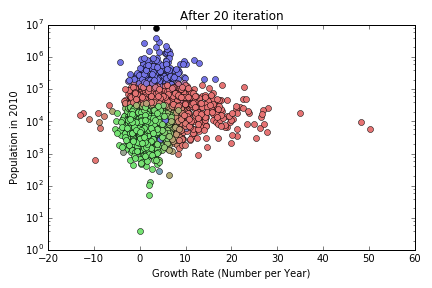

In [18]:
from IPython.display import Image
Image(filename='figures/fig_growth_rate_pop2010.png')

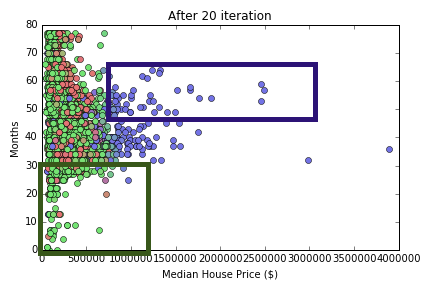

In [19]:
Image(filename='figures/fig_max_p_months_since_rectangles.png')

Let us look into more in detail regarding to the investable cities. We selected cities with median house price larger than 50,000 and tipping point time between 50 and 70 (1-3 year slower than the ealy sign cities) and population 50,000. We found 13 investable cities. All cities were located in either Washington or California: 
1. Washington State: Bellvue and Redmond
2. California State: Palo Alto, Cupertino, Sunnyvale, San Francisco, San Mateo, Redwood City, Mountain View, South San Francisco, Daly City, and Montebello

### Prediction of the future housing market crash
Now we are ready to evaluate the current housing market status and see if the next housing market crash is imminent or not. We considered house price history between 2014-01 and 2016-12 and computed the tipping points for the cities classified as ealy signs. We identified the subset of the cities (red circles in the figure below) that their median house price started to decline already. The size of the subset relative to the total number of the early sign cities (red and green circles altogether) can serve as the risk level of the housing market crash. The current level is estimated to be 34%.

In [20]:
number_top_cities = 5000
time_min = '2014-01'
time_max = '2016-12'
state = "ALL"
df_st_ALL = tipping_point(home_data, state, number_top_cities, time_min, time_max)

x = df_st_ALL['max_p']
y = df_st_ALL['months_since']

''' we conly take into account months_since <=31 since months_since =32 corresponds
to 2016-09, which is the most recent data point included in the Zillow data set.'''
p = figure(title = "Tipping-points on median house price per US city", plot_height = 300, 
           plot_width = 600, 
           x_range=(0, 2*10**6), 
           y_range=(0, 31))
p.xaxis.axis_label = 'Median House Price'
p.yaxis.axis_label = 'Months since ' + time_min

r = p.circle(graphlab.SArray(x)[1-mask_city_early_crash], graphlab.SArray(y)[1-mask_city_early_crash], 
             size=10, name = "foo", fill_alpha = 0.4, line_color=None, fill_color = 'green')
r = p.circle(graphlab.SArray(x)[mask_city_early_crash], graphlab.SArray(y)[mask_city_early_crash], 
             size=10, name = "foo", fill_alpha = 0.4, line_color=None, fill_color = 'red')
p.xaxis.formatter = NumeralTickFormatter(format="$0,0")
show(p)
number_city_early_sign = sum(mask_city_early_crash)
number_city_already_decline = sum((graphlab.SArray(y)[mask_city_early_crash]< 32))
percentage_decline = float(number_city_already_decline)/ number_city_early_sign*100
print "The current risk level of housing market crash = %d"%(percentage_decline) + "%"

The current risk level of housing market crash = 34%


### Conclusions

We identified ~250 cities that can serve as early signs for the future house market crash, based on the 2003-2009 median house prices per US city. 34% of the cities were found to already reach their tipping point (max median house prices) as of now (October 2016) and start to decrease in their median house prices. In addition, we identified most investable cities in the US, which are Bellevue and Redmond in Washington and Palo Alto, Cupertino, Sunnyvale, San Francisco, San Mateo, Redwood City, Mountain View, South San Francisco, Daly City, and Montebello in California.

In [21]:
HTML(''' <script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
</footer>''')